In [1]:
from functools import lru_cache
import torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

from torch_fouriermellin.transform import RigidTransform


image = torchvision.io.read_image('public/mandrill.png')/255.
N=20
bimage = image.unsqueeze(0).expand(N,-1,-1,-1)
gtScale = torch.rand(N)+0.55
gtAngle = torch.randint(-89, 89, (N,)).float()
gtTransX = 75*(torch.rand(N)*2-1)
gtTransY = 75*(torch.rand(N)*2-1)
bimageTransf = RigidTransform(gtScale, gtTransX, gtTransY, gtAngle)(bimage)

In [2]:
from torch_fouriermellin.registration import MellinFourierRegistration


mf = MellinFourierRegistration(*bimage.shape[-2:])
ans = mf.register_image(bimage, bimageTransf)
imageTransfRegistered = ans['registered']


In [3]:
mf.get_parameters_domain()

{'tyRange': torch.return_types.aminmax(
 min=tensor(-256),
 max=tensor(255)),
 'txRange': torch.return_types.aminmax(
 min=tensor(-256),
 max=tensor(255)),
 'rotRange': torch.return_types.aminmax(
 min=tensor(-89.),
 max=tensor(90.)),
 'scaleRange': torch.return_types.aminmax(
 min=tensor(0.0534),
 max=tensor(19.0263))}

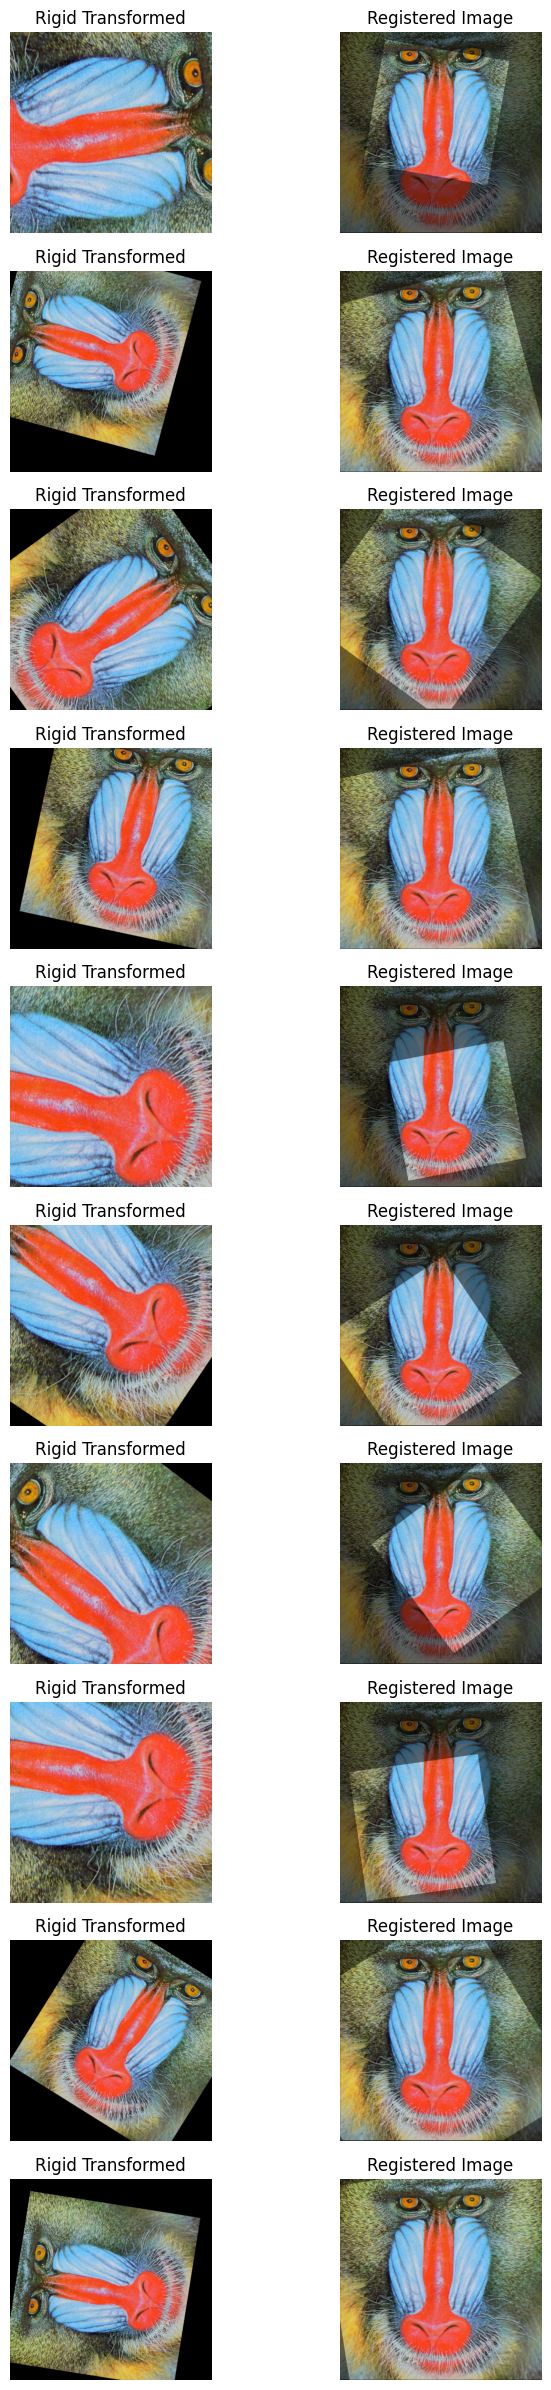

In [4]:

fig, axs = plt.subplots(10, 2, figsize=(8, 24))
for i in range(10):
    axs[i, 0].imshow(bimageTransf[i].moveaxis(0,-1))
    axs[i, 0].set_title('Rigid Transformed')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(imageTransfRegistered[i].moveaxis(0,-1))
    axs[i, 1].set_title('Registered Image')
    axs[i, 1].imshow(bimage[i].moveaxis(0,-1), alpha=0.5)
    axs[i, 1].axis('off')
plt.tight_layout()
plt.show()